# Weather Data Analysis and Route Optimization

This notebook demonstrates how to:
1. Import weather data from Copernicus
2. Process wind and temperature data
3. Implement an A* pathfinding algorithm for route optimization

## Setup: Installing Required APIs

We'll use the [Atmosphere Data Store (ADS)](https://ads.atmosphere.copernicus.eu/) API to download weather data. This requires:
1. An ADS account
2. The ADS API client
3. Supporting Python packages

In [2]:
#pip install xarray

```{note}
Note the exclamation mark in the line of code below. This means the code will run as a shell (as opposed to a notebook) command.
```

In [3]:
#!pip install cdsapi

## Required Libraries

We use the following Python packages:
- `cdsapi`: For accessing Copernicus data
- `zipfile`: For handling downloaded data
- `numpy` & `pandas`: For data processing
- `xarray`: For handling multidimensional data
- `matplotlib` & `cartopy`: For visualization

In [4]:
# CDS API
import cdsapi

# Library to extract data
from zipfile import ZipFile

# Libraries to read and process arrays
import numpy as np
import xarray as xr
import pandas as pd

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Access data

To access data from the ADS, you will need first to register (if you have not already done so), by visiting https://ads.atmosphere.copernicus.eu/ and selecting **"Login/Register"**

To obtain data programmatically from the ADS, you will need an API Key. This can be found in the page https://ads.atmosphere.copernicus.eu/how-to-api. Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS. Your API key is the entire string of characters that appears after `key:`

Now copy your API key into the code cell below, replacing `#######` with your key.

In [ ]:
URL = 'https://ads.atmosphere.copernicus.eu/api'

# Replace the hashtags with your key:
KEY = 'a1ab2026-72e3-4aeb-aeca-348a78244ff7'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [6]:
DATADIR = 'C:/Users/Antoine.Scherpereel/Downloads/'

## Data Source: CAMS Global Atmospheric Composition

The data comes from the CAMS Global Atmospheric Composition Forecast dataset, which provides:
- Wind components (U and V)
- Temperature data
- Various atmospheric measurements

Key characteristics:
- Temporal resolution: hourly forecasts
- Spatial coverage: Custom area selection
- Multiple atmospheric variables

## Data Parameters

Selected parameters for this analysis:
- **Variables**: 
  - 10m wind components (U, V)
  - 2m temperature
  - Additional atmospheric variables
- **Time Range**: Single day forecast
- **Area**: European region (Focused on France)
- **Format**: NetCDF (Network Common Data Form)

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [7]:
dataset = "cams-global-atmospheric-composition-forecasts"
request = {
    "date": ["2025-05-17/2025-05-17"],
    "time": ["00:00"],
    "leadtime_hour": [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12"
    ],
    "pressure_level": ["500"],
    "area": [52, -6, 42, 10],
    "type": ["forecast"],
    'data_format': 'netcdf_zip',
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind"
    ]
}


client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request).download(f'{DATADIR}/2021-08_AOD.zip')

2025-05-18 09:22:25,864 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-18 09:22:27,012 INFO Request ID is c216f655-3ba4-468c-8f79-e80992ad1fa7
2025-05-18 09:22:27,098 INFO status has been updated to accepted
2025-05-18 09:22:35,536 INFO status has been updated to running
2025-05-18 09:22:48,532 INFO status has been updated to successful


'C:/Users/Antoine.Scherpereel/Downloads//2021-08_AOD.zip'

## Data Processing

The workflow consists of:
1. Reading NetCDF data using Xarray
2. Processing meteorological variables
3. Implementing route optimization
4. Visualizing results

Xarray provides efficient handling of labeled multi-dimensional arrays, particularly suited for meteorological data.

First we extract the downloaded zip file:

In [8]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/2021-08_AOD.zip', 'r') as zipObj:
   # Extract all the contents of zip file into a directory
   zipObj.extractall(path=f'{DATADIR}/2021-08_AOD/')

For convenience, we create a variable with the name of our downloaded file:

In [9]:
fn = f'{DATADIR}/2021-08_AOD/data_sfc.nc'

Now we can read the data into an Xarray dataset:

In [10]:

# Create Xarray Dataset
ds = xr.open_dataset(fn)

C:\Users\Antoine.Scherpereel\AppData\Local\Temp\ipykernel_22132\3941446314.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(fn)


Let's see how this looks by querying our newly created Xarray dataset ...

In [11]:
ds

<xarray.Dataset> Size: 167kB
Dimensions:                  (forecast_period: 13, forecast_reference_time: 1,
                              latitude: 26, longitude: 41)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 104B 00:00:00 ...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2025...
  * latitude                 (latitude) float64 208B 52.0 51.6 ... 42.4 42.0
  * longitude                (longitude) float64 328B -6.0 -5.6 ... 9.6 10.0
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 104B ...
Data variables:
    u10                      (forecast_period, forecast_reference_time, latitude, longitude) float32 55kB ...
    v10                      (forecast_period, forecast_reference_time, latitude, longitude) float32 55kB ...
    t2m                      (forecast_period, forecast_reference_time, latitude, longitude) float32 55kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-18T07:21 GRIB to CDM+CF via cfgrib-0.9.1...

We see that the dataset has three variables. Selecting the "show/hide attributes" icons reveals their names: **"omaod550"** is "Organic Matter Aerosol Optical Depth at 550nm", **"aod550"** is "Total Aerosol Optical Depth at 550nm" and **"duaod550"** is "Dust Aerosol Optical Depth at 550nm".
The dataset also has four coordinates of **longitude**, **latitude**, **forecast_reference_time** and **forecast_period**.

We will now look more carefully at the "Total Aerosol Optical Depth at 550nm" dataset.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **aod550** data easier, we convert in into an Xarray data array.

## Data Analysis Methods

The analysis includes:
1. Temporal subsetting
2. Spatial analysis
3. Weather parameter visualization
4. Route optimization using A* algorithm

Reference: [Xarray Documentation](https://docs.xarray.dev/en/stable/user-guide/indexing.html)

### Temporal subset

By inspecting the array, we notice that the second of the four dimensions is time. If we wish to select only one time step, the easiest way to do this is to use positional indexing. The code below creates a Data Array of only the first time step.

In [1]:
# Import required libraries for processing and visualization
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select variables of interest at the first time step
temperature = ds['t2m'].isel(forecast_period=0, forecast_reference_time=0) - 273.15  # Convert from K to °C
u10 = ds['u10'].isel(forecast_period=0, forecast_reference_time=0)  # U component of wind
v10 = ds['v10'].isel(forecast_period=0, forecast_reference_time=0)  # V component of wind

# Create three separate plots for temperature and wind components

# Create a figure with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot temperature
temperature.plot(ax=ax, cmap='coolwarm', cbar_kwargs={'label': 'Temperature (°C)'})
ax.set_title('Temperature Map')
ax.coastlines()
plt.show()

# Plot U component of wind
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
u10.plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'Wind U Component (m/s)'})
ax.set_title('Wind U Map')
ax.coastlines('10m')
plt.show()

# Plot V component of wind
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
v10.plot(ax=ax, cmap='Greens', cbar_kwargs={'label': 'Wind V Component (m/s)'})
ax.set_title('Wind V Map')
ax.coastlines()
plt.show()

NameError: name 'ds' is not defined

## A* Algorithm for Route Optimization

The A* pathfinding algorithm optimizes routes considering:
1. Wind conditions (U and V components)
2. Temperature variations
3. Geographic constraints

Key features:
- Heuristic-based path finding
- Weather-aware cost function
- Efficient grid navigation

C:\Users\Antoine.Scherpereel\AppData\Local\Temp\ipykernel_22132\1433153492.py:100: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if 0 <= neighbor[0] < ds.dims['latitude'] and 0 <= neighbor[1] < ds.dims['longitude']:


Goal reached in 10 iterations


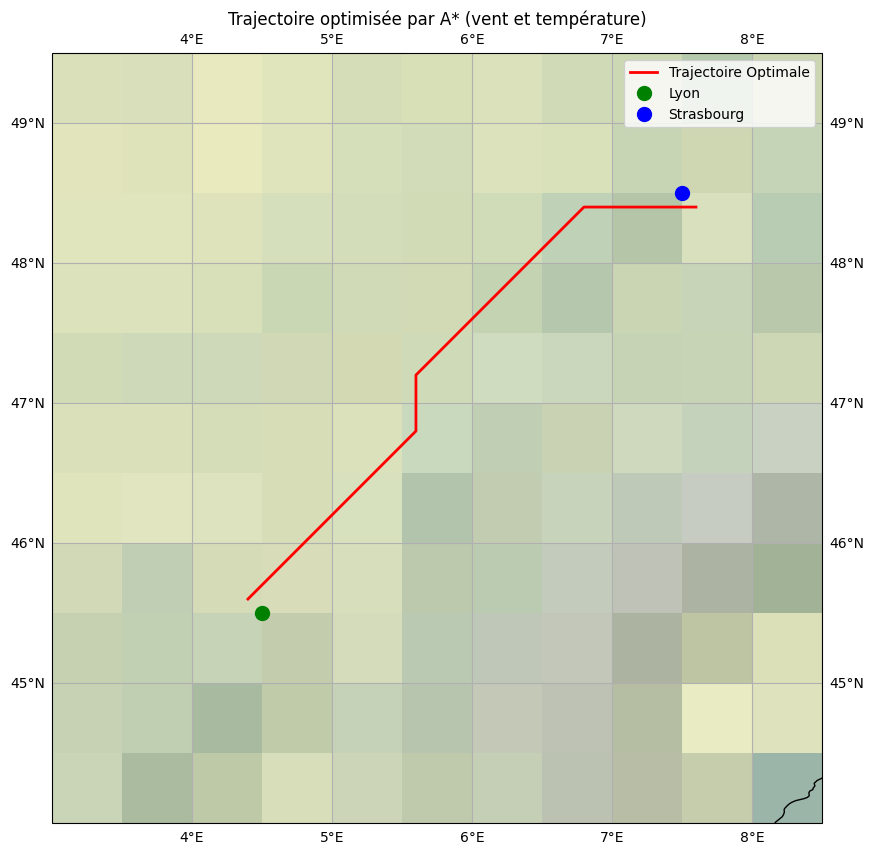

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import heapq

# Extract first timestep data
u10 = ds['u10'].isel(forecast_period=0, forecast_reference_time=0)
v10 = ds['v10'].isel(forecast_period=0, forecast_reference_time=0)
t2m = ds['t2m'].isel(forecast_period=0, forecast_reference_time=0) - 273.15  # Convert to Celsius

# Define start and end points
lyon = (45.5, 4.5)
strasbourg = (48.5, 7.5)

def find_nearest_grid_point(lat_val, lon_val):
    """Find the closest grid point to given lat/lon coordinates"""
    i = np.abs(ds.latitude - lat_val).argmin().item()
    j = np.abs(ds.longitude - lon_val).argmin().item()
    return (i, j)

def heuristic(a, b):
    """Calculate Euclidean distance heuristic between two points"""
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def is_towards_goal(current, neighbor, goal):
    """Check if moving to neighbor brings us closer to goal"""
    v_current_to_goal = np.array([goal[0]-current[0], goal[1]-current[1]])
    v_current_to_neighbor = np.array([neighbor[0]-current[0], neighbor[1]-current[1]])
    dot = np.dot(v_current_to_goal, v_current_to_neighbor)
    return dot > 0

def cost(current, neighbor):
    """Calculate movement cost considering wind and temperature
    
    Parameters:
    - current: Current grid position
    - neighbor: Next grid position
    
    Returns:
    - Combined cost based on distance, wind effect, and temperature penalty
    """
    cy, cx = current
    ny, nx = neighbor

    # Basic distance cost
    base_dist = np.sqrt((cy - ny) ** 2 + (cx - nx) ** 2)

    # Wind effect calculation
    uy = u10.values[cy, cx]
    vy = v10.values[cy, cx]
    wind_vector = np.array([uy, vy])
    dir_vector = np.array([nx - cx, ny - cy])
    wind_effect = np.dot(dir_vector, wind_vector)

    # Temperature penalty (deviation from ideal 15°C)
    t = t2m.values[ny, nx]
    temp_penalty = abs(t - 15) / 10

    return base_dist - 0.5 * wind_effect + 0.5 * temp_penalty

def a_star(start, goal, max_iterations=10000):
    """A* pathfinding algorithm implementation
    
    Parameters:
    - start: Starting grid point
    - goal: Target grid point
    - max_iterations: Maximum number of iterations to prevent infinite loops
    
    Returns:
    - List of points forming the optimal path
    """
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    iteration = 0
    while open_set and iteration < max_iterations:
        iteration += 1
        if iteration % 100 == 0:
            print(f"Iteration {iteration} - open set size: {len(open_set)}")

        _, current = heapq.heappop(open_set)

        if current == goal:
            print(f"Goal reached in {iteration} iterations")
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                neighbor = (current[0] + dy, current[1] + dx)
                if 0 <= neighbor[0] < ds.dims['latitude'] and 0 <= neighbor[1] < ds.dims['longitude']:
                    if not is_towards_goal(current, neighbor, goal):
                        continue
                    tentative_g = g_score[current] + cost(current, neighbor)
                    if tentative_g < g_score.get(neighbor, float("inf")):
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g
                        f_score[neighbor] = tentative_g + heuristic(neighbor, goal)
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))

    print(f"Goal not reached after {iteration} iterations (limit reached)")
    return None

# Calculate path and visualize
start = find_nearest_grid_point(*lyon)
goal = find_nearest_grid_point(*strasbourg)
path = a_star(start, goal)

# Extract coordinates for visualization
lat_path = [ds.latitude.values[p[0]] for p in path]
lon_path = [ds.longitude.values[p[1]] for p in path]

# Create visualization
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([3, 8.5, 44, 49.5], crs=ccrs.PlateCarree())

# Background map
ax.stock_img()

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

# Trajectory
ax.plot(lon_path, lat_path, color='red', linewidth=2, label="Optimal Trajectory")

# Start and end points (lon, lat)
ax.plot(lyon[1], lyon[0], 'go', markersize=10, label='Lyon')
ax.plot(strasbourg[1], strasbourg[0], 'bo', markersize=10, label='Strasbourg')

ax.legend()
plt.title("A* Optimized Trajectory (wind and temperature)")
plt.show()

C:\Users\Antoine.Scherpereel\AppData\Local\Temp\ipykernel_22132\1433153492.py:100: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if 0 <= neighbor[0] < ds.dims['latitude'] and 0 <= neighbor[1] < ds.dims['longitude']:


Iteration 100 - open set size: 91
Iteration 200 - open set size: 83
Iteration 300 - open set size: 117
Iteration 400 - open set size: 189
Iteration 500 - open set size: 145
Iteration 600 - open set size: 118
Iteration 700 - open set size: 95
Iteration 800 - open set size: 106
Iteration 900 - open set size: 61
Goal reached in 901 iterations


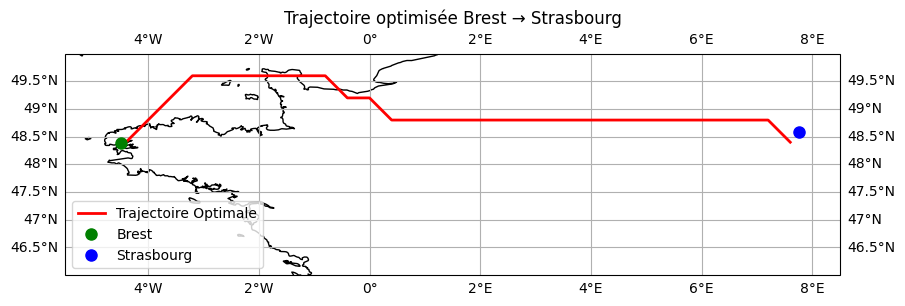

In [ ]:
# Define new coordinates for the route
brest = (48.39, -4.49)      # Coordinates for Brest (lat, lon)
strasbourg = (48.58, 7.75)  # Coordinates for Strasbourg (lat, lon)

# Update start and end points for pathfinding
start = find_nearest_grid_point(*brest)
goal = find_nearest_grid_point(*strasbourg)

# Calculate optimal path using A* algorithm
path = a_star(start, goal)

# Check if a valid path was found
if path is not None:
    # Extract latitude and longitude coordinates for plotting
    lat_path = [ds.latitude.values[p[0]] for p in path]
    lon_path = [ds.longitude.values[p[1]] for p in path]

    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    
    # Set map boundaries for France
    ax.set_extent([-5.5, 8.5, 46, 50], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution="10m")
    ax.gridlines(draw_labels=True)
    
    # Plot optimal trajectory
    ax.plot(lon_path, lat_path, color='red', linewidth=2, label="Optimal Trajectory")
    
    # Add markers for start and end points
    ax.plot(brest[1], brest[0], 'go', markersize=8, label='Brest')
    ax.plot(strasbourg[1], strasbourg[0], 'bo', markersize=8, label='Strasbourg')
    
    # Add legend and title
    ax.legend()
    plt.title("Optimized Trajectory Brest → Strasbourg")
    plt.show()
else:
    print("❌ No path found.")